In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [56]:
data_path = "Data/heart.csv"
df = pd.read_csv(data_path)

In [57]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [58]:
start = len(df)

In [59]:
df = df[df['caa'] < 4] #drop the wrong ca values
df = df[df['thall'] > 0] # drop the wong thal value
print(f'The length of the data now is {len(df)} instead of {start}')

The length of the data now is 296 instead of 303


In [60]:
# Sprawdzenie pierwszych kilku wierszy danych
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [61]:
# Podstawowe informacje o danych
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    int64  
 1   sex       296 non-null    int64  
 2   cp        296 non-null    int64  
 3   trtbps    296 non-null    int64  
 4   chol      296 non-null    int64  
 5   fbs       296 non-null    int64  
 6   restecg   296 non-null    int64  
 7   thalachh  296 non-null    int64  
 8   exng      296 non-null    int64  
 9   oldpeak   296 non-null    float64
 10  slp       296 non-null    int64  
 11  caa       296 non-null    int64  
 12  thall     296 non-null    int64  
 13  output    296 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 34.7 KB


In [62]:
# Statystyki opisowe
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,296.000000,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,1.395270,0.679054,2.327703,0.540541
std,9.059471,0.467631,1.034184,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.618235,0.939726,0.585743,0.499198
min,29.000000,0.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [63]:
# Convert specific columns to 'category' dtype
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Verify the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       296 non-null    int64   
 1   sex       296 non-null    category
 2   cp        296 non-null    category
 3   trtbps    296 non-null    int64   
 4   chol      296 non-null    int64   
 5   fbs       296 non-null    category
 6   restecg   296 non-null    category
 7   thalachh  296 non-null    int64   
 8   exng      296 non-null    category
 9   oldpeak   296 non-null    float64 
 10  slp       296 non-null    category
 11  caa       296 non-null    category
 12  thall     296 non-null    category
 13  output    296 non-null    int64   
dtypes: category(8), float64(1), int64(5)
memory usage: 19.6 KB


## EDA

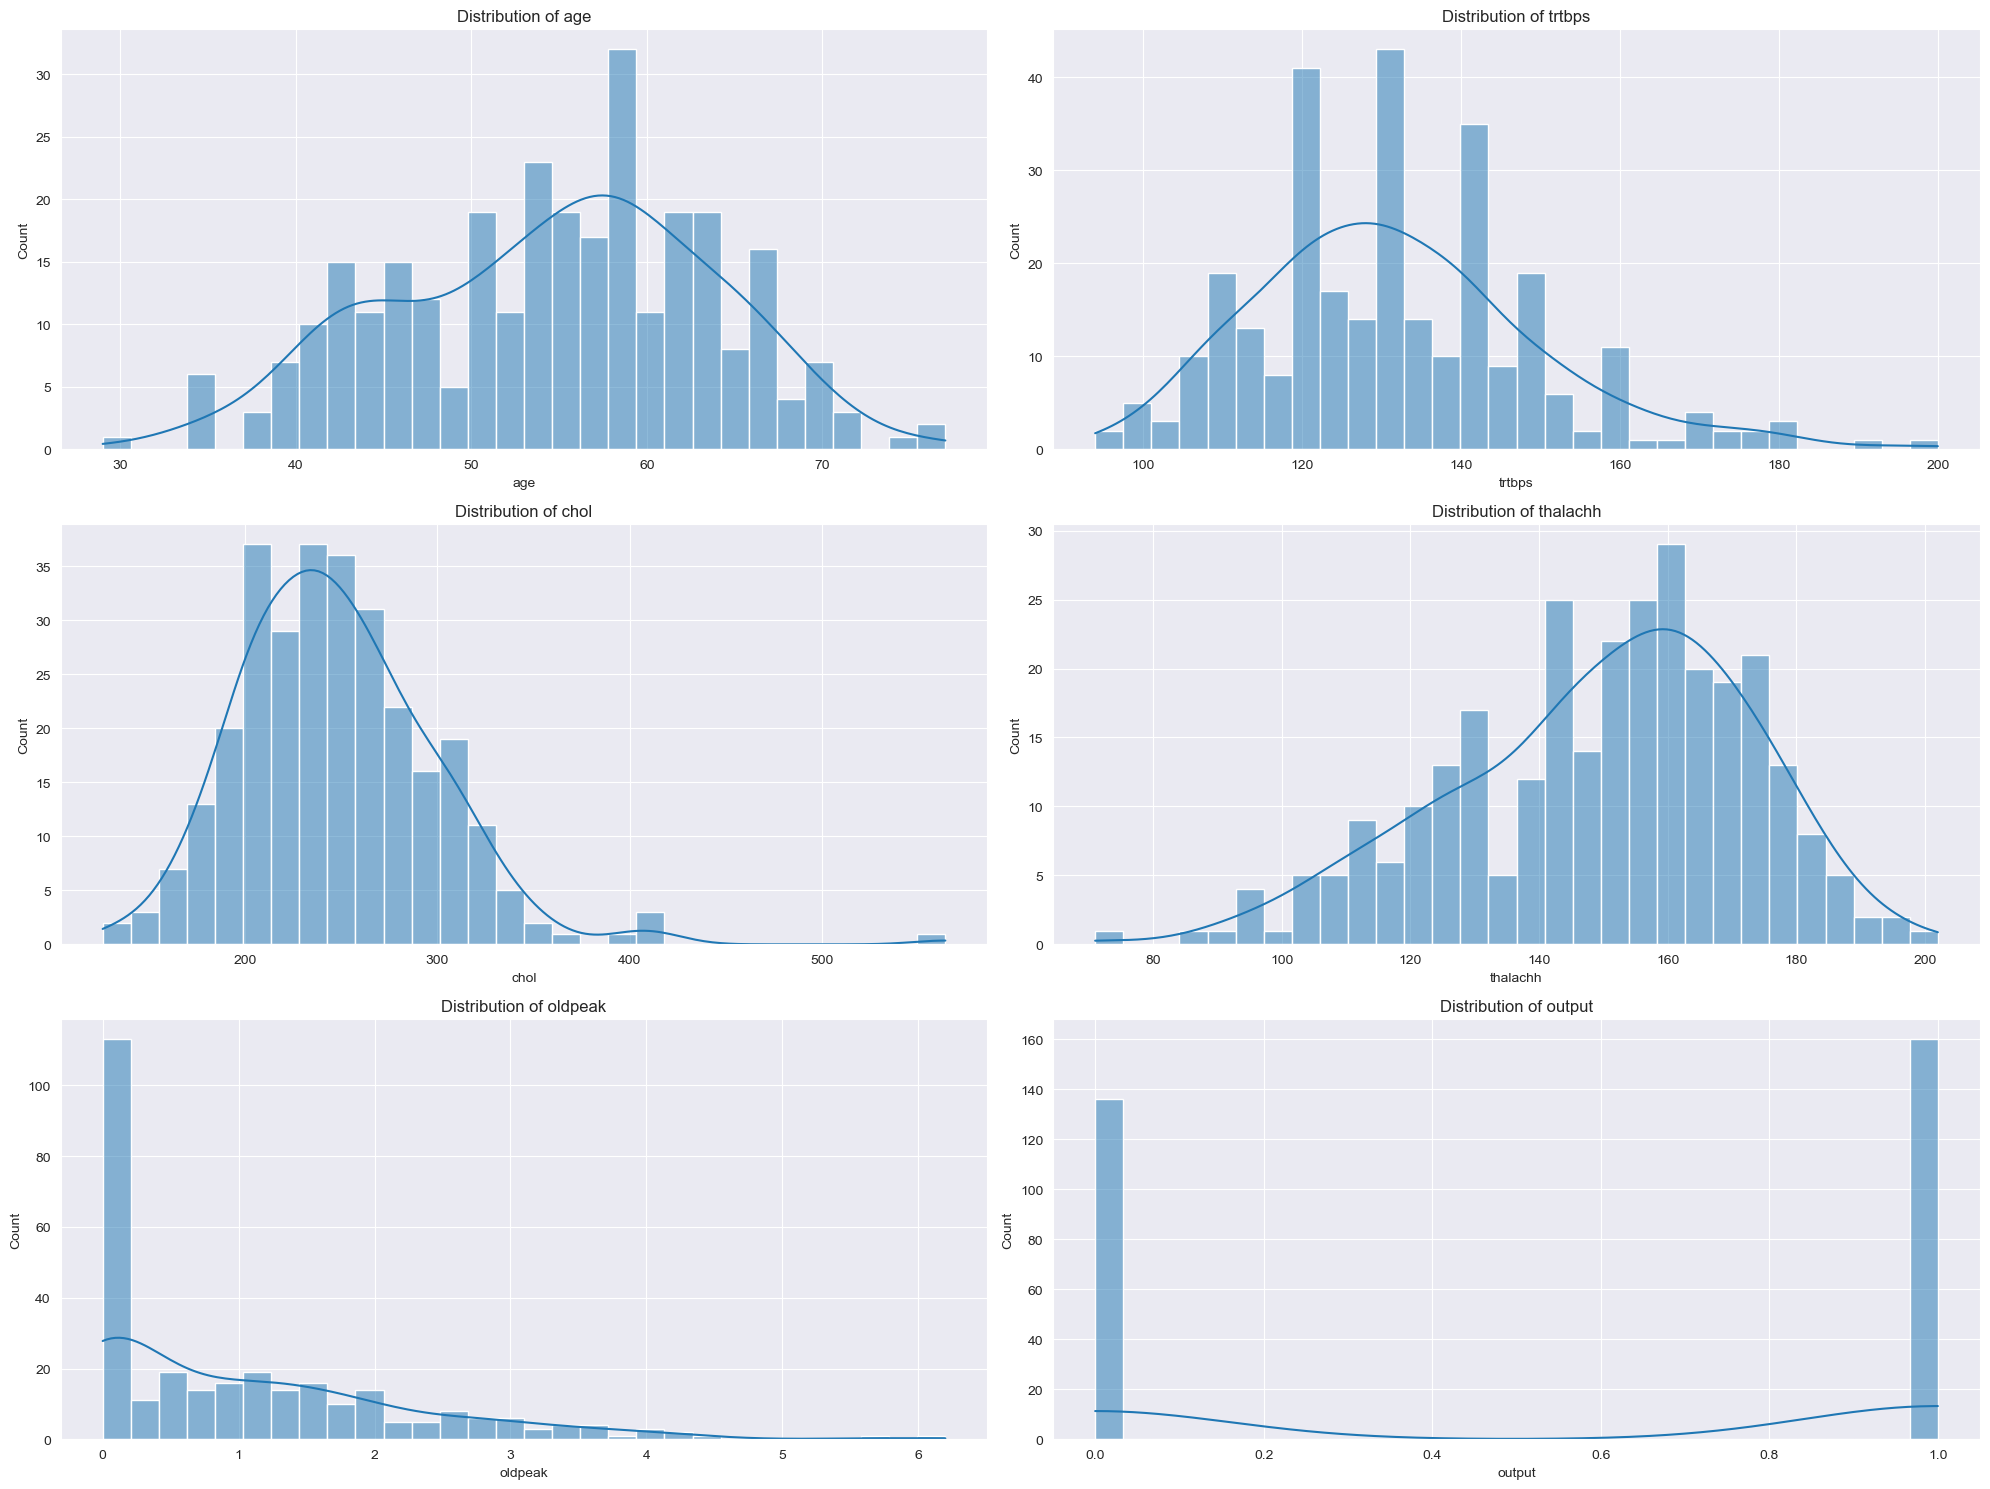

In [64]:
plt.figure(figsize=(20, 15))

numerical_columns = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.savefig('EDA/numerical_distributions.png')  # Save the plot
plt.show()

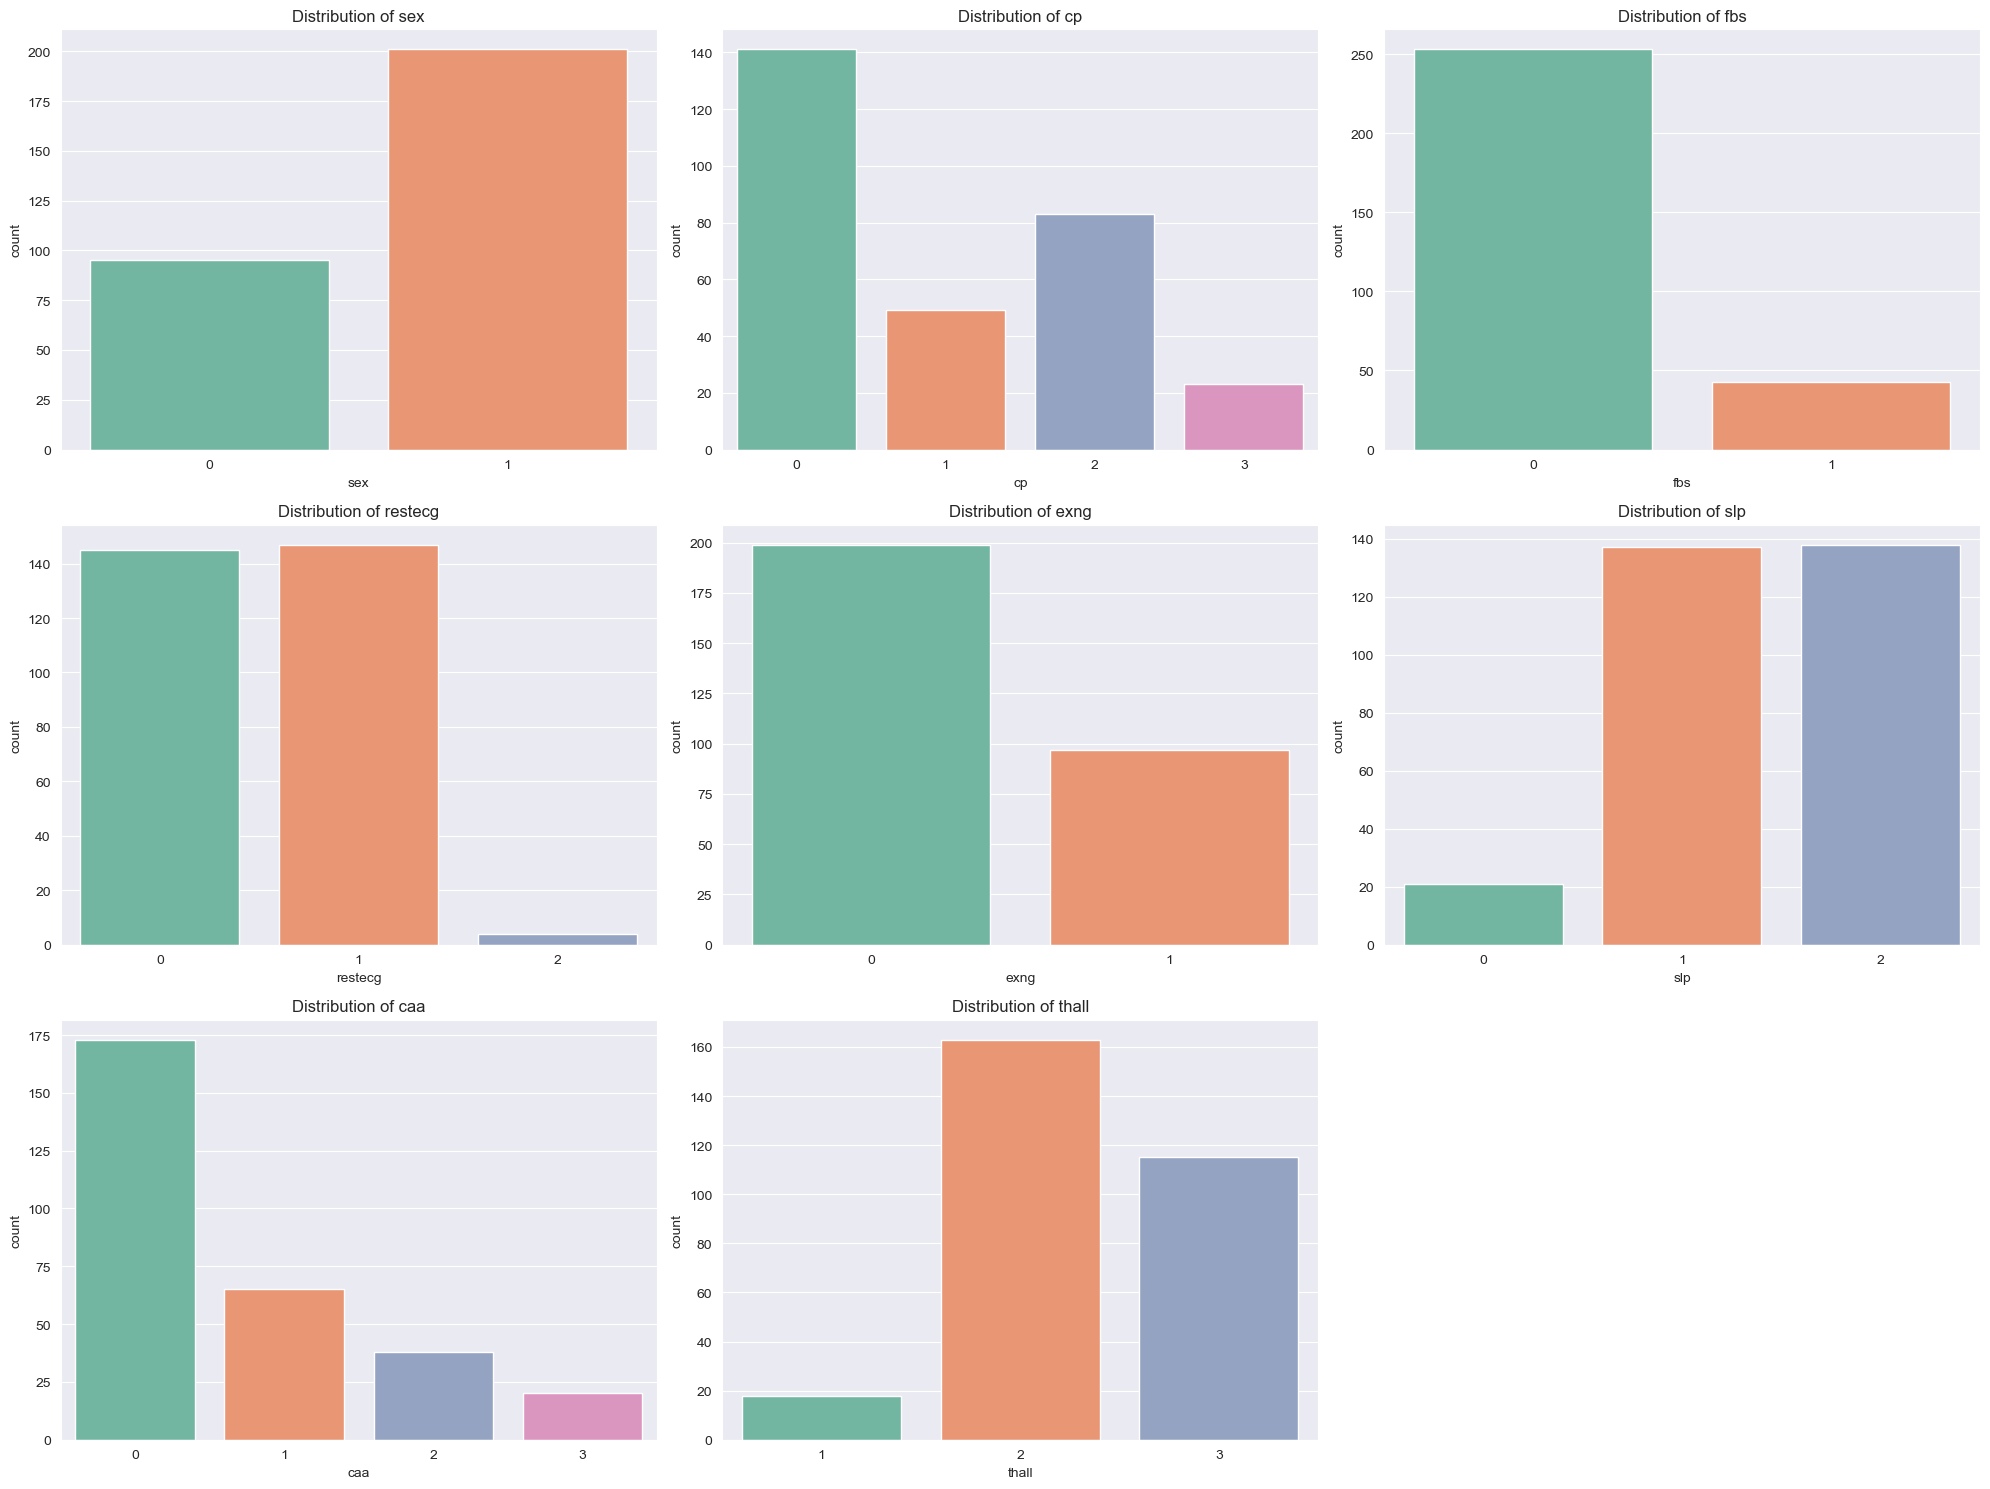

In [65]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Loop through categorical columns and create count plots
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df[col], hue=df[col], palette='Set2', legend=False)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.savefig('EDA/categorical_distributions.png')  # Save the plot
plt.show()

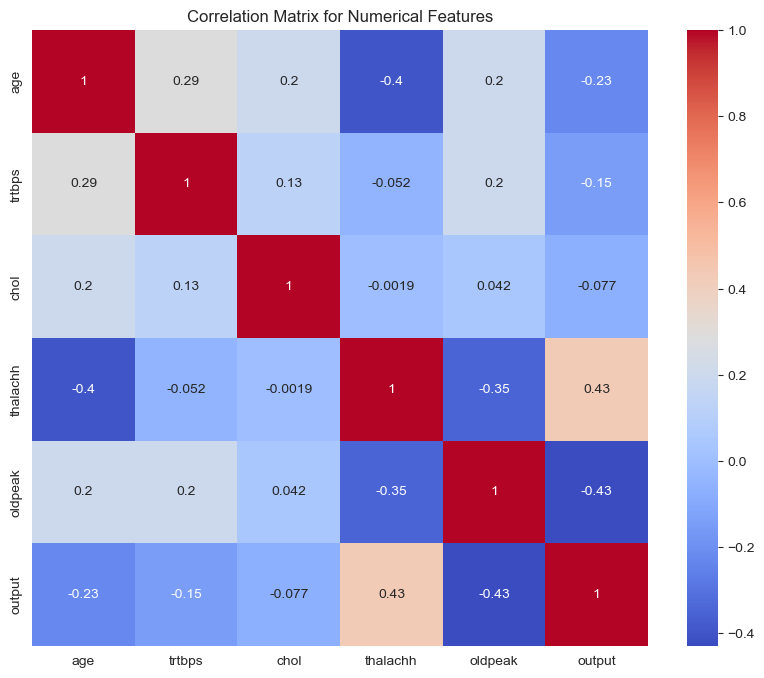

In [66]:
# Compute the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Numerical Features')

plt.savefig('EDA/correlation_matrix.png')  # Save the plot
plt.show()

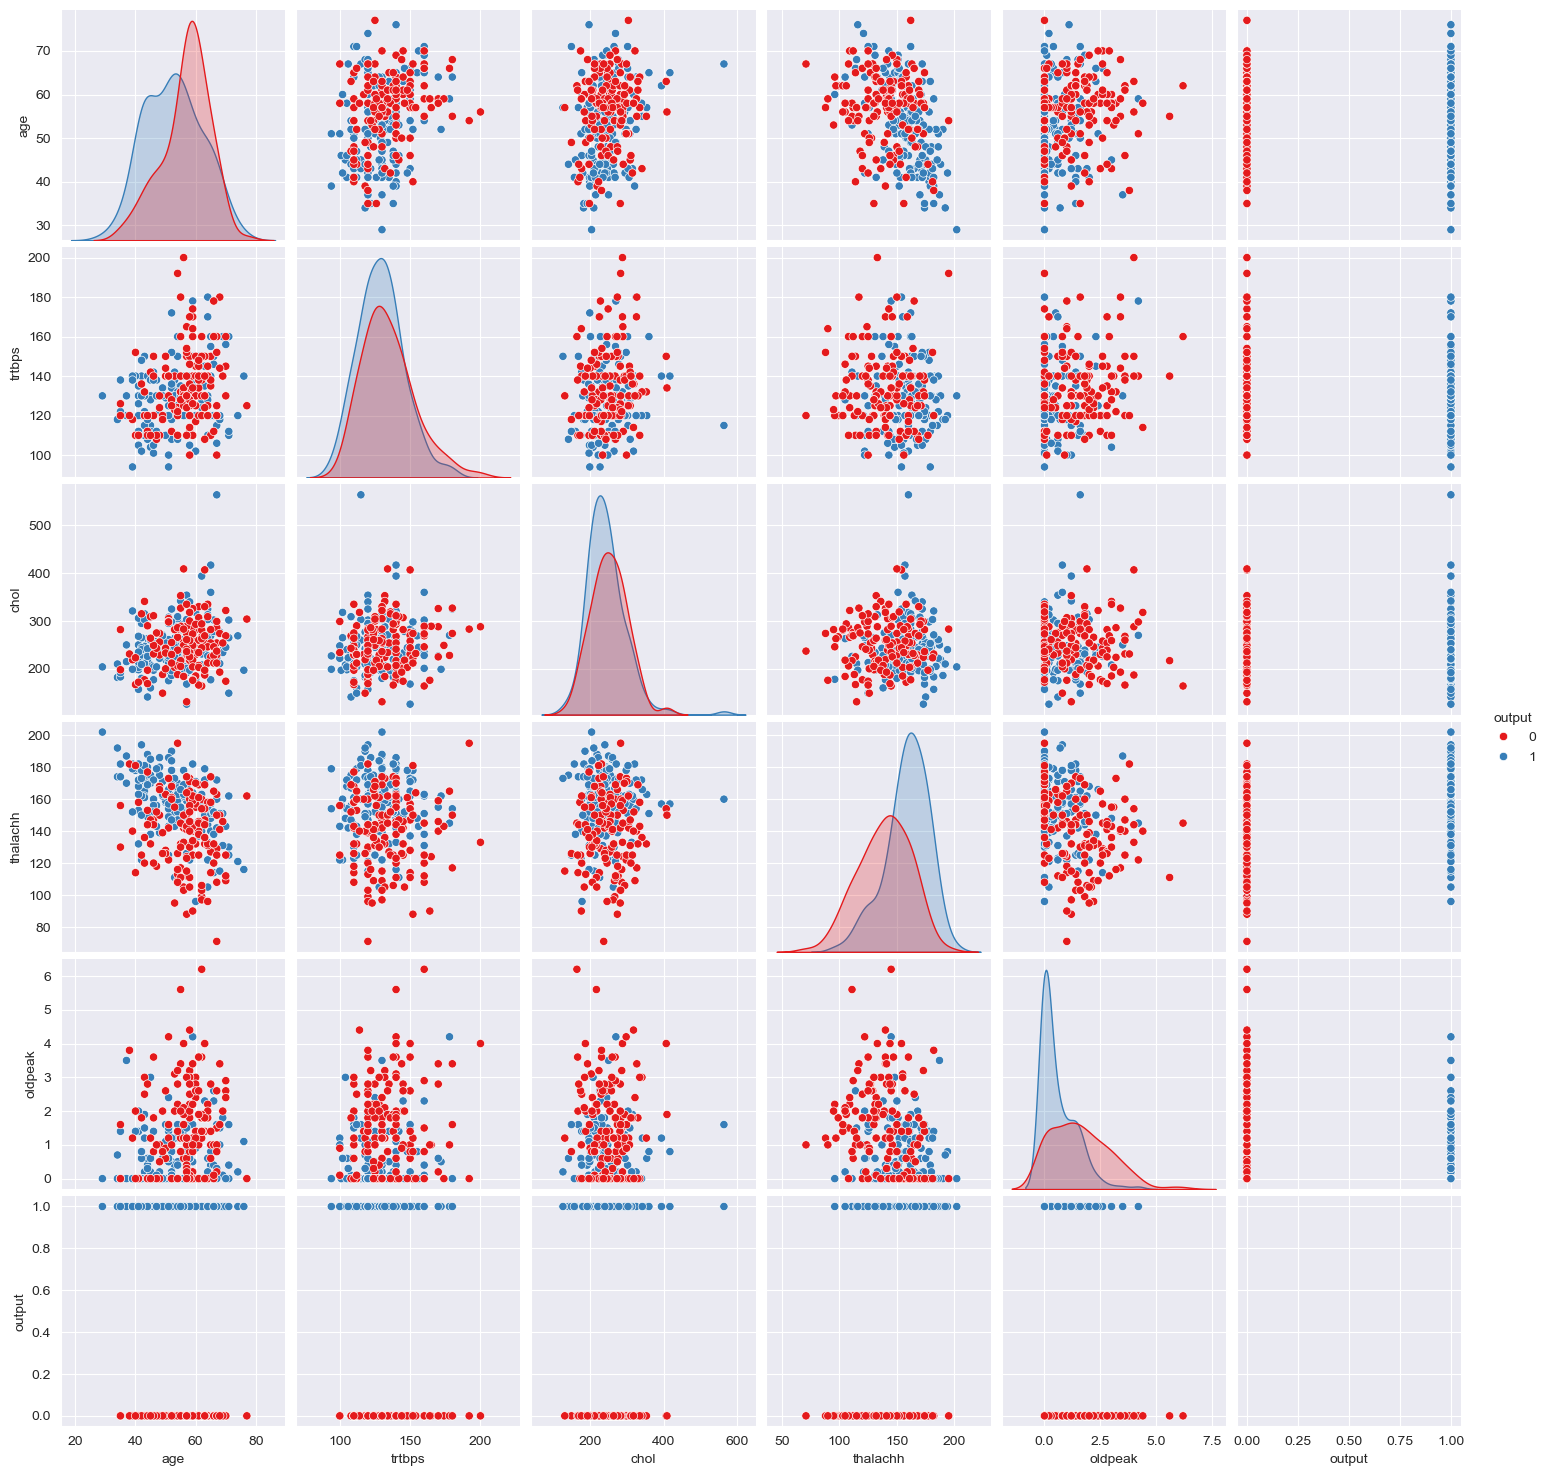

In [67]:
# Pair plot to see the relationships between numerical features and output
sns.pairplot(df, hue='output', vars=numerical_columns, palette='Set1')

plt.savefig('EDA/pairplot.png')  # Save the plot
plt.show()

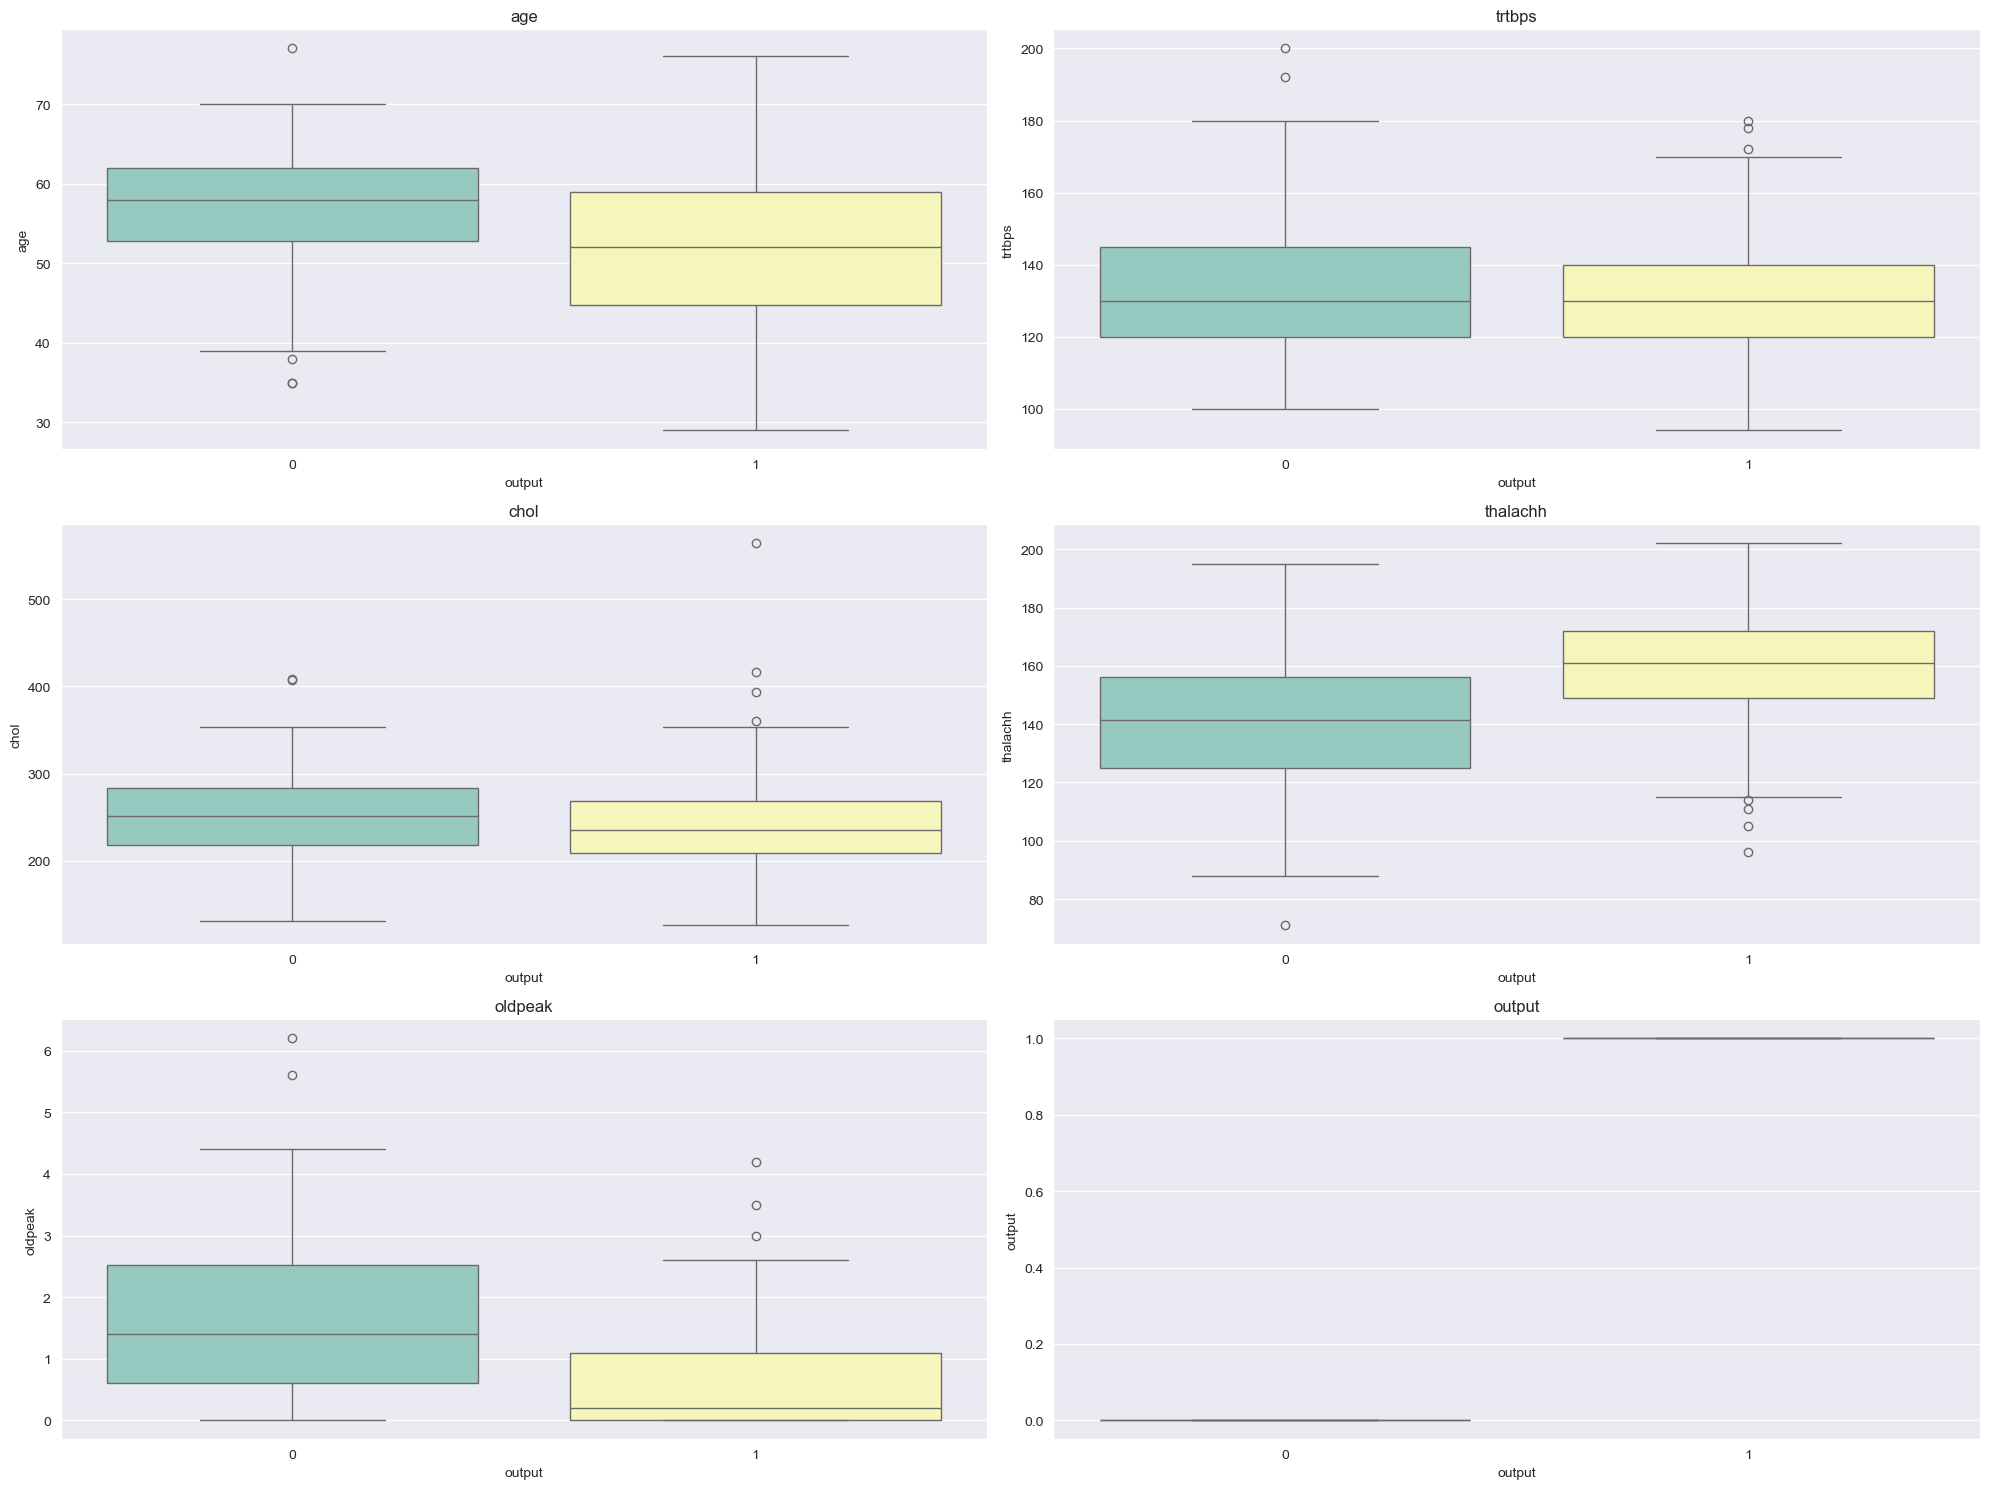

In [68]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Loop through numerical columns and create box plots by output
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=df['output'], y=df[col], hue=df['output'], palette='Set3', legend=False)
    plt.title(f'{col}')

plt.tight_layout()
plt.savefig('EDA/numerical.png')  # Save the plot
plt.show()

In [69]:
# Separate features and target variable
X = df.drop(['output'], axis=1)  # drop the target variable
y = df['output']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
# Select categorical and numerical columns
numerical_columns = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']

# Define preprocessing for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

# Combine preprocessing for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Apply preprocessing to the training and test sets
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

2024/08/11 16:15:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3e0dbb753e9a42a7a19d38d5238c0920', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/08/11 16:15:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "D:\Programy\Anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https:/

In [71]:
# Verify the final shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (236, 13), X_test shape: (60, 13)
y_train shape: (236,), y_test shape: (60,)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=180; total time=   0.1s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=200; tot

2024/08/11 16:22:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 283 runs will be omitted.


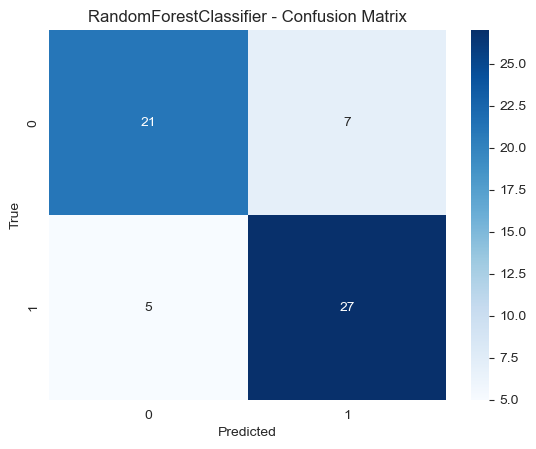

Zakończono eksperyment MLflow.


In [72]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Zaktualizowana przestrzeń przeszukiwania dla GridSearchCV
param_grid = {
    'n_estimators': [180, 200, 220, 250],
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt', None]
}

# Konfiguracja MLflow
experiment_name = "HeartAttack - Random Forest"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment(experiment_name)
mlflow.sklearn.autolog()

# Konwersja y_train i y_test do tablic NumPy
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

X_train = X_train.astype(float)
X_test = X_test.astype(float)

with mlflow.start_run():
    # RandomForestClassifier z GridSearchCV
    rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               cv=5, scoring='roc_auc', verbose=2)
    
    # Trenowanie modelu
    grid_search.fit(X_train, y_train_array)
    best_model = grid_search.best_estimator_

    # Przewidywanie na zbiorze testowym
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Logowanie macierzy konfuzji jako obraz
    cm = confusion_matrix(y_test_array, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('RandomForestClassifier - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    cm_image_path = "Results/confusion_matrix_rf_grid_search.png"
    plt.savefig(cm_image_path)
    mlflow.log_artifact(cm_image_path, "plots")
    plt.show()

    # Logowanie pełnego raportu klasyfikacji
    classification_rep = classification_report(y_test_array, y_pred, output_dict=True)
    mlflow.log_dict(classification_rep, "Results/classification_report.json")

    # Logowanie metryk dla zbioru testowego
    mlflow.log_metrics({
        "test_accuracy_score": accuracy_score(y_test_array, y_pred),
        "test_f1_score": f1_score(y_test_array, y_pred),
        "test_log_loss": log_loss(y_test_array, y_pred_proba),
        "test_precision_score": precision_score(y_test_array, y_pred),
        "test_recall_score": recall_score(y_test_array, y_pred),
        "test_roc_auc": roc_auc_score(y_test_array, y_pred_proba)
    })

    # Logowanie najlepszego modelu i jego parametrów
    mlflow.log_params(grid_search.best_params_)
    mlflow.sklearn.log_model(best_model, "BestRandomForestModel" ,input_example=X_test[:5])

print("Zakończono eksperyment MLflow.")